In [1]:
#importing necessary libraries
from api.mapbox_api_walking import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod

In [2]:
#reading in library branch and population demographics, both with geometry data
branchInfo = gpd.read_file('../data/clean/branches.csv')
censusTracts = pd.read_csv('../data/clean/population_demographics.csv')

In [3]:
#removing unecessary columns from branchInfo
branchInfo = branchInfo.drop(columns = ['HOURS OF OPERATION', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE','PERMANENTLY_CLOSED'])
#removing unecessary columns from censusTracts
censusTracts = censusTracts[['geoid','geometry','qualifying name']]

In [4]:
#converting censusTracts to a geodataframe (we could not load it as one since it already had a geometry column so we are simply
#converting the geometry column to a proper gpd geometry column).
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

In [5]:
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


In [6]:
#helper method to ensure that two polygons overlap before getting the intersection. Gets the intersection then calculates
#the percent of overlapping area for a census tract and saves it to a dictionary with the census tract geo-id as the key and
#the percent as the value.
def check(polygon1, df, geoname, dictionary,key):
   
    for i in range(len(df)):
        if polygon1.intersects(df.loc[i,geoname]): 
            overlapPolygon = (polygon1.intersection(df.loc[i,geoname]))
            poly_area, poly_perimeter = geod.geometry_area_perimeter(overlapPolygon)
            overlapArea = poly_area*-1
            propOverlap = overlapArea / df.loc[i,'Area']
            #print(propOverlap)
            dictionary[df.loc[i, key]] = propOverlap
    return dictionary
   

In [7]:
#sets the crs of gpd types
def geoSetup(gdf):
    
    gdf = gdf.set_crs('EPSG:4326')
    

In [8]:
#cdf = gdf of geometry area which you want to get the coverage score
#idf = gdf of points for which you want to get an isochrone and dictionary of percent of overlap in cdf areas
#scoreString = a string that is the name of the coverage score column you choose
#dictString = a string that is the name of the dictionary column you choose
#cgs = a string that is the name of the geometry column in the cdf
#igs = a string that is the name of the geometry column in the idf
#lat = a string that is the name of the latitude column in the idf
#lon = a string that is the name of the longitude column in the idf
#key = a string that is the name of the column in the cdf that you want to represent the key of the dictionary
#travelTime = an integer of the amount of time traveled you wish to calculate the isochrone

def appendADS(cdf,idf,scoreString,dictString,cgs,igs,lat,lon,key,travelTime):
    
    api = MapboxAPI()
    cdf[scoreString] = 0.0
    idf[dictString] = ''
    censusAreas = []
    global geod 
    geod = Geod(ellps='WGS84')
   
    geoSetup(cdf)
    geoSetup(idf)
   
    for index, row in cdf.iterrows():
        poly_area, poly_perimeter = geod.geometry_area_perimeter(row[cgs])
        poly_area = poly_area*-1
        censusAreas.append(poly_area)
    
    cdf['Area'] = censusAreas



    for i in range(len(idf)):
        dictionary = {}
        api_response =  api.get_data((idf.loc[i,lat],idf.loc[i,lon]), travelTime)
        idf.loc[i,igs] = shape(api_response)
        dictionary = check(idf.loc[i,igs],cdf,cgs, dictionary,key)
        branchInfo.loc[i,dictString]= [dictionary]
    
        for i in range(len(cdf)):
   
            if dictionary.get(cdf.loc[i, key]) != None:
                score = cdf.loc[i, scoreString]
                cdf.loc[i, scoreString] = score + dictionary.get(cdf.loc[i, key])
  
          

In [9]:
appendADS(censusTracts,branchInfo, 'score', 'list of dict','geometry','geometry','LATITUDE','LONGITUDE','geoid',5)

api = MapboxAPI()
censusTracts['score'] = 0.0
branchInfo['dictionary'] = ''
censusAreas = []
#geod = Geod(ellps='WGS84')
censusTracts = censusTracts.set_crs('EPSG:4326')
branchInfo = branchInfo.set_crs('EPSG:4326')
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


for index, row in censusTracts.iterrows():
    poly_area, poly_perimeter = geod.geometry_area_perimeter(row['geometry'])
    poly_area = poly_area*-1
    censusAreas.append(poly_area)
censusTracts['calculated area'] = censusAreas



for i in range(len(branchInfo)):
    dictionary = {}
    api_response =  api.get_data((branchInfo.loc[i,'LATITUDE'],branchInfo.loc[i,'LONGITUDE']), 5)
    branchInfo.loc[i,'geometry'] = shape(api_response)
    dictionary = check(branchInfo.loc[i,'geometry'],censusTracts,'geometry', dictionary)
    branchInfo.loc[i,'dictionary']= [dictionary]
    
    for i in range(len(censusTracts)):
   
        if dictionary.get(censusTracts.loc[i, 'geoid']) != None:
            score = censusTracts.loc[i, 'score']
            censusTracts.loc[i, 'score'] = score + dictionary.get(censusTracts.loc[i, 'geoid'])
  
          

In [10]:
branchInfo

,BRANCH,LOCATION,geometry,LATITUDE,LONGITUDE,list of dict
0,Albany Park,"(41.97557881655979, -87.71361314512697)","POLYGON ((-87.71361 41.97980, -87.71561 41.978...",41.975579,-87.713613,"[{17031140200: 0.024261414648178242, 170318318..."
1,Altgeld,"(41.65719847558056, -87.59883829075173)","POLYGON ((-87.59884 41.65834, -87.60070 41.658...",41.657198,-87.598838,"[{17031540101: 0.03491984488141061, 1703154010..."
2,Archer Heights,"(41.80110836194246, -87.72648385568911)","POLYGON ((-87.72448 41.80420, -87.72548 41.804...",41.801108,-87.726484,"[{17031620200: 0.02526108935346498, 1703157050..."
3,Austin,"(41.88917312206642, -87.7658203582574)","POLYGON ((-87.76482 41.89291, -87.76682 41.892...",41.889173,-87.765820,"[{17031252000: 0.05497457992904844, 1703125190..."
4,Austin-Irving,"(41.95312267684315, -87.77928489355646)","POLYGON ((-87.77929 41.95731, -87.78029 41.956...",41.953123,-87.779285,"[{17031150600: 0.05455724158718237, 1703117020..."
...,...,...,...,...,...,...
77,West Pullman,"(41.67790647382097, -87.6431683153105)","POLYGON ((-87.64217 41.68127, -87.64517 41.680...",41.677906,-87.643168,"[{17031530400: 0.0918500236428569, 17031530501..."
78,West Town,"(41.89594730478282, -87.66829305460979)","POLYGON ((-87.66729 41.89945, -87.67029 41.899...",41.895947,-87.668293,"[{17031243100: 0.02980340076829326, 1703124330..."
79,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)","POLYGON ((-87.61495 41.75509, -87.61695 41.753...",41.751018,-87.614951,"[{17031440300: 0.09273338664328809, 1703169130..."
80,Woodson Regional Library,"(41.720694885749005, -87.64304817213312)","POLYGON ((-87.64305 41.72473, -87.64744 41.721...",41.720695,-87.643048,"[{17031730500: 0.11148406556499087, 1703173010..."


In [11]:
censusTracts.sort_values(by = 'score', ascending = False)

,geoid,qualifying name,geometry,score,Area
375,17031283200,"Census Tract 2832, Cook County, Illinois","POLYGON ((-87.66120 41.87212, -87.66103 41.872...",1.240733,236545.662330
658,17031062500,"Census Tract 625, Cook County, Illinois","POLYGON ((-87.67309 41.94328, -87.67197 41.943...",0.991274,161002.041916
540,17031230100,"Census Tract 2301, Cook County, Illinois","POLYGON ((-87.70683 41.91029, -87.70681 41.910...",0.849052,166340.560749
303,17031381400,"Census Tract 3814, Cook County, Illinois","POLYGON ((-87.62576 41.80924, -87.62527 41.809...",0.824040,316691.634836
737,17031040900,"Census Tract 409, Cook County, Illinois","POLYGON ((-87.68855 41.96487, -87.68818 41.964...",0.801413,321853.924327
...,...,...,...,...,...
357,17031840200,"Census Tract 8402, Cook County, Illinois","POLYGON ((-87.65707 41.84819, -87.65677 41.848...",0.000000,862870.353397
359,17031310400,"Census Tract 3104, Cook County, Illinois","POLYGON ((-87.65319 41.85981, -87.65314 41.859...",0.000000,124462.683355
360,17031310300,"Census Tract 3103, Cook County, Illinois","POLYGON ((-87.65143 41.85802, -87.65103 41.858...",0.000000,318569.231958
361,17031310200,"Census Tract 3102, Cook County, Illinois","POLYGON ((-87.64658 41.85991, -87.64645 41.859...",0.000000,320571.633879


Text(0.5, 1.0, 'Percent of Coverage')

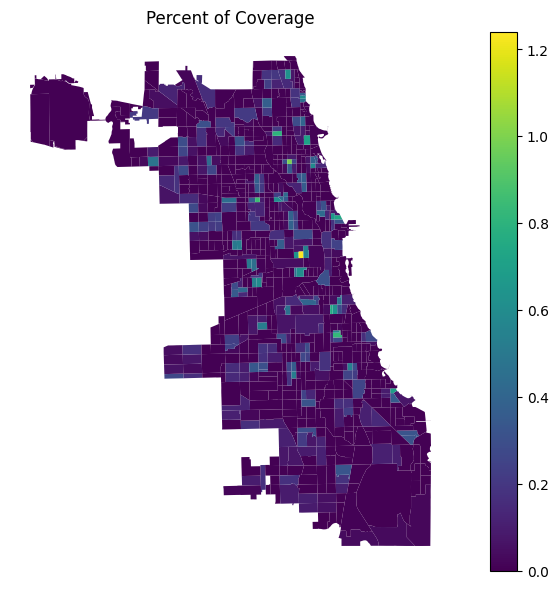

In [12]:
ax = censusTracts.plot(column = 'score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of Coverage")

In [13]:
censusTracts['score'].mean()

0.07232693135889712